In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import xgboost

%matplotlib inline

# Import data
data = pd.read_csv('../data/data_all_features.csv')
minimal_data = pd.read_csv('../data/data_selected_features.csv')
train_test_data = pickle.load(open("../data/train_test_data_all_features", "rb"))
minimal_train_test_data = pickle.load(open("../data/train_test_data_selected_features", "rb"))
model = pickle.load(open("../data/xgb_model_pickle_v2", "rb"))

# Get samples
sample_data = train_test_data['X_test'].assign(show_up = train_test_data['y_test']).reset_index(drop=True)
minimal_sample_data = minimal_train_test_data['X_test'].assign(show_up = minimal_train_test_data['y_test']).reset_index(drop=True)

np.random.seed(42)
indices = np.random.randint(0, len(train_test_data['y_test']), 10)
sample = sample_data.loc[indices]
minimal_sample = minimal_sample_data.loc[indices]

zero_sample = minimal_train_test_data['X_test'].assign(show_up = minimal_train_test_data['y_test']).reset_index(drop = True)
zero_sample = zero_sample[zero_sample['show_up'] == 0].reset_index(drop = True)

X_train = minimal_train_test_data['X_train']
X_test = minimal_train_test_data['X_test']
y_train = minimal_train_test_data['y_train']
y_test = minimal_train_test_data['y_test']
X_test_zero = zero_sample.drop('show_up', axis=1)
y_test_zero = zero_sample.loc[:, 'show_up']
y_test_zero[0] = 1 # Inserts an 1 so that doesn't mess with metrics

/opt/conda/lib/python3.6/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


# Starting data

In [1]:
import pandas as pd
import numpy as np
import pickle
from helper import preprocess_minimal_data

minimal_data = pd.read_csv('../data/minimal_data.csv')
X_train, X_test, y_train, y_test, cluster_train, cluster_test, normalizer = preprocess_minimal_data(minimal_data)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


# Logistic Regression

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, fbeta_score, confusion_matrix, accuracy_score

lr_clf = LogisticRegression(solver='lbfgs')
lr_model = lr_clf.fit(X_train, y_train)

In [24]:
y_pred = lr_model.predict(X_test)
print('pos_label 1')
print(f1_score(y_test, y_pred))
print(fbeta_score(y_test, y_pred, beta=0.5))
print('\npos_label 0')
print(f1_score(y_test, y_pred, pos_label=0))
print(fbeta_score(y_test, y_pred, beta=0.5, pos_label=0))
print(np.mean(y_pred))
print('\naccuracy_score')
print(accuracy_score(y_test, y_pred))

pos_label 1
0.00488145048815
0.0119904076739

pos_label 0
0.820231796422
0.740879816117
0.00181391378574

accuracy_score
0.695475885617


In [40]:
confusion_matrix(y_test, y_pred, labels=[0, 1])

array([[   56, 22752],
       [   80, 52088]])

# XGBoost

In [66]:
from sklearn.metrics import make_scorer, f1_score, fbeta_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

grid_params = {
    'max_depth': [7, 9],
    'learning_rate': [0.9, 1.1]
}

xgb_clf = XGBClassifier(n_estimators=50, n_jobs=4, silent=False)

scorer = make_scorer(f1_score)

def custom_f1_eval(y_pred, y_true):
    labels = y_true.get_label()
    y_bin = [1. if y_cont > 0.5 else 0. for y_cont in y_pred]
    return 'inverse_f1_score', 1 - f1_score(labels, y_bin)

grid = GridSearchCV(xgb_clf, grid_params, cv=3, n_jobs=-1, verbose=True, scoring=scorer)

In [67]:
fit_params = {
    'eval_set': [(X_test, y_test)],
    'eval_metric': custom_f1_eval,
    'verbose': False
}

grid = grid.fit(X_train, y_train, **fit_params)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  3.0min finished


In [74]:
models = {}
n = 0
max_depths = [3, 5, 7, 9, 11]
learning_rates = [0.7, 0.9, 1.1, 1.3]
for md in max_depths:
    for lr in learning_rates:
        clf = XGBClassifier(n_estimators=50, n_jobs=4, max_depth=md, learning_rate=lr, silent=False)
        clf = clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric=custom_eval, verbose=False)
        params = {'max_depth': md, 'learning_rate': lr}
        models[n] = {'model': clf, 'params': params}
        n += 1

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Text(0.5,1,'f1-score over grown trees')

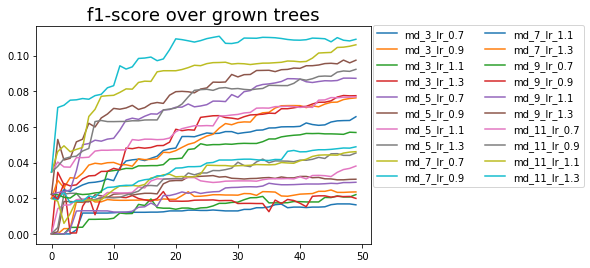

In [97]:
for i in models:
    scores = np.array([1.0 - s for s in models[i]['model'].evals_result_['validation_0']['inverse_f1_score']])
    label = 'md_' + str(models[i]['params']['max_depth']) + '_lr_' + str(models[i]['params']['learning_rate'])
    plt.plot(scores, label=label)
plt.legend(ncol=2, loc=1, bbox_to_anchor=(1.65, 1.03))
plt.title('f1-score over grown trees', fontsize=18)

# Exporting models

In [10]:
# # Export lr model
# with open('../data/lr_model', 'wb') as f:
#     pickle.dump(lr_model, f)

# # Export grid
# with open('../data/xgb_grid_v1', 'wb') as f:
#     pickle.dump(grid, f)

# # Export xgb model
# with open('../data/xgb_model_v1', 'wb') as f:
#     pickle.dump(grid.best_estimator_, f)

# Ignored

In [99]:
from sklearn.metrics import make_scorer, f1_score, fbeta_score
from xgboost import XGBClassifier

clf = XGBClassifier(n_estimators=2000, n_jobs=4, silent=False, max_depth=11, learning_rate=1.1)

def custom_eval(y_pred, y_true):
    labels = y_true.get_label()
    y_bin = [1. if y_cont > 0.5 else 0. for y_cont in y_pred]
    # return 'f1_score', f1_score(labels, y_bin)
    return 'inverse_f1_score', 1 - f1_score(labels, y_bin)

model = clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric=custom_eval, early_stopping_rounds=200, verbose=True)

[0]	validation_0-error:0.305885	validation_0-inverse_f1_score:0.965317
Multiple eval metrics have been passed: 'validation_0-inverse_f1_score' will be used for early stopping.

Will train until validation_0-inverse_f1_score hasn't improved in 200 rounds.
[1]	validation_0-error:0.306685	validation_0-inverse_f1_score:0.953791
[2]	validation_0-error:0.307365	validation_0-inverse_f1_score:0.950584
[3]	validation_0-error:0.307405	validation_0-inverse_f1_score:0.953895
[4]	validation_0-error:0.307672	validation_0-inverse_f1_score:0.952593
[5]	validation_0-error:0.308179	validation_0-inverse_f1_score:0.951491
[6]	validation_0-error:0.309499	validation_0-inverse_f1_score:0.934141
[7]	validation_0-error:0.309739	validation_0-inverse_f1_score:0.930148
[8]	validation_0-error:0.310379	validation_0-inverse_f1_score:0.92283
[9]	validation_0-error:0.310473	validation_0-inverse_f1_score:0.922486
[10]	validation_0-error:0.310499	validation_0-inverse_f1_score:0.922272
[11]	validation_0-error:0.310579	va

In [20]:
from sklearn.metrics import accuracy_score
preds = model.predict(X_test)

In [39]:
import matplotlib.pyplot as plt

In [43]:
preds = model.predict(X_test)

In [41]:
np.mean(model.predict(X_test))

0.024301109688433631

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.9, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=4, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=False, subsample=1)

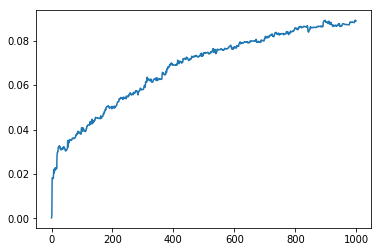

In [53]:
import matplotlib.pyplot as plt
scores = np.array([1.0 - s for s in model.evals_result_['validation_0']['inverse_f1_score']])
plt.plot(scores)

In [25]:
accuracy_score(y_test, preds)
f1_score(y_test, preds)

0.69523580879214686

In [61]:
# Define cutoff for probabilities
cutoff = 0.7

# Calculates predictions for X_test
pred = model.predict(X_test)
prob = np.array([i[1] for i in model.predict_proba(X_test)])
prob_bin = np.array([1.0 if p > cutoff else 0.0 for p in prob])

# Calculates predictions for X_test_zero
pred_zero = model.predict(X_test_zero)
prob_zero = np.array([i[1] for i in model.predict_proba(X_test_zero)])
prob_bin_zero = np.array([1.0 if p > cutoff else 0.0 for p in prob_zero])

In [62]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(pred, y_test))
print(confusion_matrix(pred, y_test))
print('-' * 60)
print(classification_report(pred_zero, y_test_zero))
print(confusion_matrix(pred_zero, y_test_zero))

              precision    recall  f1-score   support

           0       0.01      0.53      0.02       367
           1       1.00      0.70      0.82     74633

   micro avg       0.70      0.70      0.70     75000
   macro avg       0.50      0.61      0.42     75000
weighted avg       0.99      0.70      0.82     75000

[[  193   174]
 [22388 52245]]
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.01      1.00      0.02       193
           1       1.00      0.00      0.00     22388

   micro avg       0.01      0.01      0.01     22581
   macro avg       0.50      0.50      0.01     22581
weighted avg       0.99      0.01      0.00     22581

[[  193     0]
 [22387     1]]


In [66]:
from sklearn.metrics import fbeta_score
print('fbeta_score zero:')
print(fbeta_score(prob_bin_zero, y_test_zero, beta=0.5))
print('\nfbeta_score all:')
print(fbeta_score(prob_bin, y_test, beta=0.5))

fbeta_score zero:
0.000532481363152

fbeta_score all:
0.590148885972


Confusion matrix, without normalization
[[  101 22480]
 [  102 52317]]


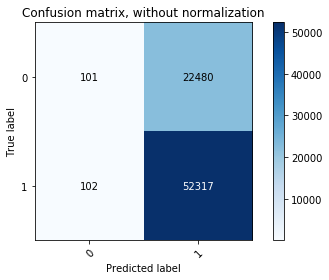

In [56]:
plot_confusion_matrix(np.array(y_test), pred, classes=np.array([0, 1]))

Confusion matrix, without normalization
[[  101 22479]
 [    0     1]]


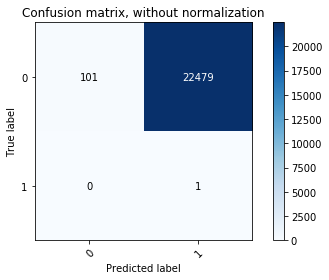

In [57]:
plot_confusion_matrix(np.array(y_test_zero), pred_zero, classes=np.array([0, 1]))

In [48]:
from sklearn import svm, datasets
a = datasets.load_iris()

In [52]:
a.target_names[[0, 1, 2]]

array(['setosa', 'versicolor', 'virginica'], 
      dtype='<U10')

# Feature Selection

<BarContainer object of 19 artists>

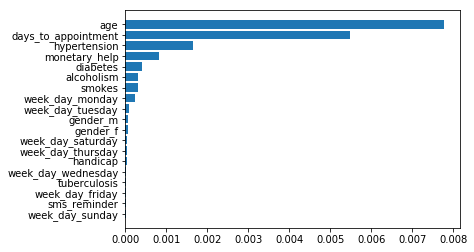

In [2]:
from helper import intersect_features
from sklearn.feature_selection import mutual_info_classif

discrete_idx = [i for i in range(2, 19)]
selection_scores = mutual_info_classif(train_test_data['X_train'], train_test_data['y_train'], discrete_idx)
mi_table = pd.DataFrame({'var': train_test_data['X_train'].columns, 'mi': selection_scores}).sort_values('mi', ascending=True)

plt.barh(mi_table['var'], mi_table['mi'])

<BarContainer object of 19 artists>

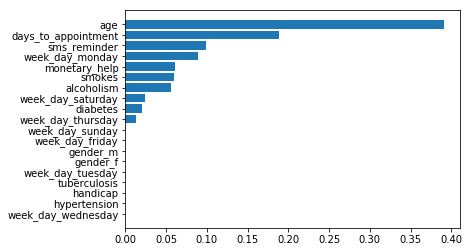

In [3]:
selection_table = pd.DataFrame({'var': train_test_data['X_train'].columns, 'mi': model.feature_importances_}).sort_values('mi', ascending=True)

plt.barh(selection_table['var'], selection_table['mi'])

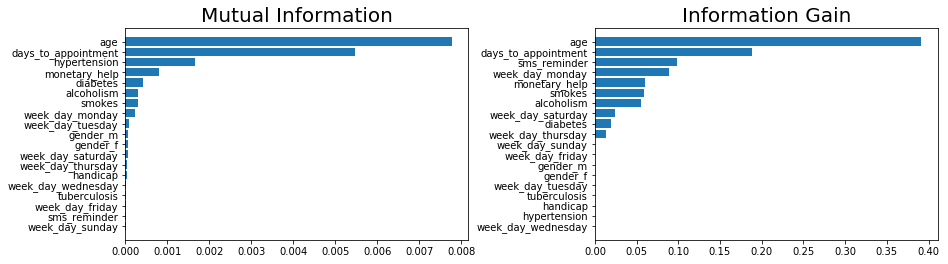

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(13, 3.5))
ax[0].barh(mi_table['var'], mi_table['mi'])
ax[0].set_title('Mutual Information', fontsize=20)
ax[1].barh(selection_table['var'], selection_table['mi'])
ax[1].set_title('Information Gain', fontsize=20)
plt.tight_layout(pad=0.1)#, w_pad=0.5, h_pad=1.0)